In [ ]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
#tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# as_supervised=True gives us the (image, label) as a tuple instead of a dict
data, info = tfds.load(name="mnist",
                       data_dir=data_dir,
                       as_supervised=True, 
                       with_info=True)

data_train = data['train']
data_test  = data['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

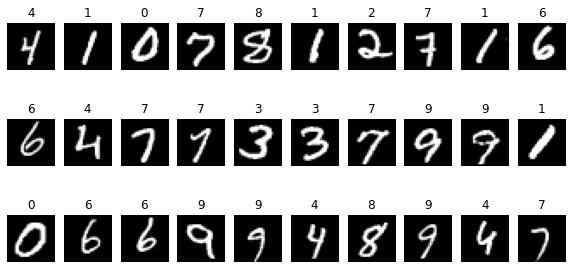

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

ROWS = 3
COLS = 10

i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(str(label.numpy()))
    ax[int(i/COLS), i%COLS].imshow(np.reshape(image, (28,28)), cmap='gray')
    i += 1
 
plt.show()

In [ ]:
HEIGHT = 28
WIDTH  = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS 
NUM_LABELS = info.features['label'].num_classes

In [ ]:
import jax.numpy as jnp

In [ ]:
def preprocess(img, label):
  """Resize and preprocess images."""
  return (tf.cast(img, tf.float32)/255.0), label

In [ ]:
data_train_vis = data_train.map(preprocess)

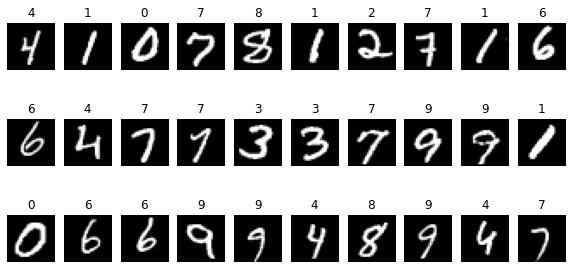

In [ ]:
i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train_vis.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(str(label.numpy()))
    ax[int(i/COLS), i%COLS].imshow(np.reshape(image, (28,28)), cmap='gray')
    i += 1
 
plt.show()

In [ ]:
train_data = tfds.as_numpy(data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(data_test.map(preprocess).batch(32).prefetch(1))

In [ ]:
LAYER_SIZES = [28*28, 512, 10]
PARAM_SCALE = 0.01

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.nn import swish, logsumexp, one_hot

In [ ]:
def init_network_params(sizes, key=random.PRNGKey(0), scale=1e-2):
  """Initialize all layers for a fully-connected neural network with given sizes"""

  def random_layer_params(m, n, key, scale=1e-2):
    """A helper function to randomly initialize weights and biases of a dense layer""" 
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [ ]:
params = init_network_params(LAYER_SIZES, random.PRNGKey(0), scale=PARAM_SCALE)

In [ ]:
def predict(params, image):
  """Function for per-example predictions."""
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

In [ ]:
random_flattened_image = random.normal(random.PRNGKey(1), (28*28*1,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [ ]:
random_flattened_images = random.normal(random.PRNGKey(1), (32, 28*28*1))
try:
  preds = predict(params, random_flattened_images)
except TypeError as e:
  print(e)

Incompatible shapes for dot: got (512, 784) and (32, 784).


In [ ]:
batched_predict = vmap(predict, in_axes=(None, 0))

In [ ]:
# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(32, 10)


In [ ]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [ ]:
INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5

In [ ]:
def loss(params, images, targets):
  """Categorical cross entropy loss function."""
  logits = batched_predict(params, images)
  log_preds = logits - logsumexp(logits) # logsumexp trick https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  return -jnp.mean(targets*log_preds)

@jit
def update(params, x, y, epoch_number):
  loss_value, grads = value_and_grad(loss)(params, x, y)
  lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
  return [(w - lr * dw, b - lr * db)
          for (w, b), (dw, db) in zip(params, grads)], loss_value

In [ ]:
num_epochs = 25

In [ ]:
@jit
def batch_accuracy(params, images, targets):
  images = jnp.reshape(images, (len(images), NUM_PIXELS))
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == targets)

def accuracy(params, data):
  accs = []
  for images, targets in data:
    accs.append(batch_accuracy(params, images, targets))
  return jnp.mean(jnp.array(accs))
  
import time

for epoch in range(num_epochs):
  start_time = time.time()
  losses = []
  for x, y in train_data:
    x = jnp.reshape(x, (len(x), NUM_PIXELS))
    y = jax.nn.one_hot(y, NUM_LABELS)
    params, loss_value = update(params, x, y, epoch)
    losses.append(loss_value)
  epoch_time = time.time() - start_time

  start_time = time.time()
  train_acc = accuracy(params, train_data)
  test_acc = accuracy(params, test_data)
  eval_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Eval in {:0.2f} sec".format(eval_time))
  print("Training set loss {}".format(jnp.mean(jnp.array(losses))))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 2.15 sec
Eval in 2.52 sec
Training set loss 0.41040700674057007
Training set accuracy 0.9299499988555908
Test set accuracy 0.931010365486145
Epoch 1 in 1.68 sec
Eval in 2.06 sec
Training set loss 0.37730318307876587
Training set accuracy 0.9500166773796082
Test set accuracy 0.9497803449630737
Epoch 2 in 1.69 sec
Eval in 2.01 sec
Training set loss 0.3708733022212982
Training set accuracy 0.9603500366210938
Test set accuracy 0.9593650102615356
Epoch 3 in 1.67 sec
Eval in 2.09 sec
Training set loss 0.36748188734054565
Training set accuracy 0.9666333198547363
Test set accuracy 0.9640575051307678
Epoch 4 in 1.68 sec
Eval in 2.10 sec
Training set loss 0.3651924729347229
Training set accuracy 0.9704166650772095
Test set accuracy 0.9673522114753723
Epoch 5 in 1.70 sec
Eval in 2.14 sec
Training set loss 0.36349743604660034
Training set accuracy 0.9737333655357361
Test set accuracy 0.9694488644599915
Epoch 6 in 1.72 sec
Eval in 2.10 sec
Training set loss 0.36217668652534485
Training s